In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import requests
import zipfile
from pathlib import Path

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
drive = '/content/drive/MyDrive/'

Mounted at /content/drive


In [ ]:
MODEL= drive+'model'


In [ ]:
# Setup path to data folder
data_path = Path(drive)
image_path = data_path / 'NDB-UFES An oral cancer and leukoplakia dataset composed of histopathological images and patient data' / 'patch'


In [ ]:
for dirpath, dirnames, filenames in os.walk(image_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 1 directories and 2 images in '/content/drive/MyDrive/NDB-UFES An oral cancer and leukoplakia dataset composed of histopathological images and patient data/patch'.
There are 0 directories and 3763 images in '/content/drive/MyDrive/NDB-UFES An oral cancer and leukoplakia dataset composed of histopathological images and patient data/patch/images'.


In [ ]:
image_path

PosixPath('/content/drive/MyDrive/NDB-UFES An oral cancer and leukoplakia dataset composed of histopathological images and patient data/patch')

In [ ]:
df_train_raw = pd.read_csv(image_path/'sabpatch_parsed_folders.csv')
df_test = pd.read_csv(image_path/'sabpatch_parsed_test.csv')
df_test.sample(3)

,path,lesion,folder,label_number
1,p3137.png,OSCC,6,1
41,p3177.png,OSCC,6,1
43,p3179.png,OSCC,6,1


In [ ]:
# df_train_raw.iloc[:,:-4].head(2)
df_train_raw.shape

(3136, 4)

In [ ]:
int(df_train_raw.shape[0]*0.85)

2665

In [ ]:
df_train = df_train_raw[:int(df_train_raw.shape[0]*0.85)]
df_val = df_train_raw[int(df_train_raw.shape[0]*0.85):]
df_train.shape, df_val.shape

((2665, 4), (471, 4))

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,
                                   shear_range=0.2,
                                  #  zoom_range=0.2,
                                   vertical_flip=True,
                                   horizontal_flip=True)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

In [ ]:
train_dataset = train_datagen.flow_from_dataframe(df_train,
                                                  x_col='path',
                                                  y_col='lesion',
                                                  target_size=(512,512),
                                                  directory=image_path/'images/',
                                                  batch_size=8,
                                                  shuffle=False,
                                                  class_mode='categorical')

val_dataset =    train_datagen.flow_from_dataframe(df_val,
                                                  x_col='path',
                                                  y_col='lesion',
                                                  target_size=(512,512),
                                                  directory=image_path/'images/',
                                                  batch_size=8,
                                                  shuffle=False,
                                                  class_mode='categorical')

test_dataset =   test_datagen.flow_from_dataframe(df_test,
                                                  x_col='path',
                                                  y_col='lesion',
                                                  target_size=(512,512),
                                                  directory=image_path/'images/',
                                                  batch_size=8,
                                                  class_mode='categorical')

Found 2665 validated image filenames belonging to 3 classes.
Found 471 validated image filenames belonging to 3 classes.
Found 627 validated image filenames belonging to 3 classes.


In [ ]:
class_idx = train_dataset.class_indices
idx_class = [i for i in class_idx.keys()]
idx_class

['OSCC', 'With dysplasia', 'Without dysplasia']

In [ ]:
len(train_dataset), train_dataset[0][0][0].shape

(334, (227, 227, 3))

In [ ]:
train_dataset[0][0][0].shape, train_dataset[0][1][0].shape

((227, 227, 3), (3,))

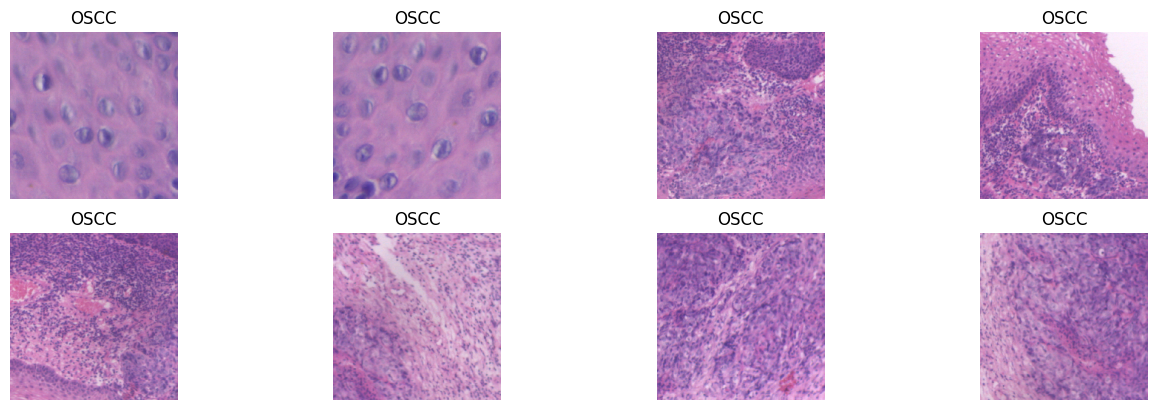

In [ ]:
plt.figure(figsize=(16,10))
for batch in train_dataset:
  for i in range(8):
    plt.subplot(4,4,i+1)
    plt.title(idx_class[np.argmax(batch[1][i])])
    plt.axis('off')
    plt.imshow(batch[0][i])
  break

In [ ]:
# train_input = df_train.iloc[:-4]
# val_input = df_val.iloc[:-4]
# test_input = df_test.iloc[:-4]

In [ ]:
input_img_shape = train_dataset[0][0][0].shape  # (512, 512, 3)

output_shape = len(idx_class) # 3

image_input = keras.layers.Input(shape=input_img_shape)

x = keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(64,64,3)) (image_input)
x = keras.layers.BatchNormalization() (x)
x = keras.layers.MaxPool2D(pool_size=(2,2)) (x)

x = keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding='same') (x)
x = keras.layers.BatchNormalization() (x)
x = keras.layers.MaxPool2D(pool_size=(3,3)) (x)

x = keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same') (x)
x = keras.layers.BatchNormalization() (x)

x = keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding='same') (x)
x = keras.layers.BatchNormalization() (x)

x = keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding='same') (x)
x = keras.layers.BatchNormalization() (x)
x = keras.layers.MaxPool2D(pool_size=(2,2)) (x)

x = keras.layers.Flatten() (x)

x = keras.layers.Dense(1024, activation='relu') (x)
x = keras.layers.Dropout(0.5) (x)

x = keras.layers.Dense(1024, activation='relu') (x)
x = keras.layers.Dropout(0.25) (x)

x = keras.layers.Dense(64, activation='relu') (x)

output_layer = keras.layers.Dense(output_shape, activation='softmax') (x)

model = keras.Model(inputs=image_input, outputs=output_layer)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 55, 55, 128)       46592     
                                                                 
 batch_normalization (Batch  (None, 55, 55, 128)       512       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       819456    
                                                                 
 batch_normalization_1 (Bat  (None, 27, 27, 256)       1024  

In [ ]:
keras.utils.plot_model(model, show_layer_activations=True, show_dtype=True, show_layer_names=True, show_shapes=True, dpi=100)

In [ ]:
# loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
# model.compile(optimizer='adam', loss=loss_function, metrics=['accuracy'])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
checkpointPath = data_path / 'model_w' / 'model1' / 'van'



mcp_point = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointPath,
                                                       save_weights_only = True,
                                                       save_best_only = True,
                                                       monitor = 'val_loss',
                                                       verbose = 1)

es_point = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=5,
                                                        verbose=1,
                                                        restore_best_weights=True,
                                                        start_from_epoch=0,)

lr_decay = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                factor=.5,
                                                patience=2,
                                                verbose=1,
                                                mode='auto')

In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, batch_size=8, callbacks=[es_point])

Epoch 1/10
334/334 [==============================] - 154s 419ms/step - loss: 1.2158 - accuracy: 0.4559 - val_loss: 1.0577 - val_accuracy: 0.6837
Epoch 2/10
334/334 [==============================] - 67s 200ms/step - loss: 1.1095 - accuracy: 0.4799 - val_loss: 1.0231 - val_accuracy: 0.6837
Epoch 3/10
160/334 [=============>................] - ETA: 28s - loss: 1.0699 - accuracy: 0.5082

KeyboardInterrupt: 

In [ ]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

In [ ]:
fig, axes = plt.subplots(1,2 , figsize = (15,6))
props = dict(boxstyle='round', facecolor='aqua',alpha=.5)

l_range = 50
ax = axes[0]
y1=loss_df.columns[0]
y2=loss_df.columns[2]
best = loss_df[loss_df['val_loss'] == loss_df['val_loss'].min()]


loss_df.plot(y=[y1,y2],ax=ax)
ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);
# little beautification
txtstr = "Errors: \nloss      : {:6.4f}\nval_loss: {:6.4f}".format(best.loss.values[0],
                                                                    best.val_loss.values[0]) #text to plot

# place a text box in upper left in axes coords
ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title(y1.capitalize())
ax.grid();

ax = axes[1]

y1=loss_df.columns[1]
y2=loss_df.columns[3]

loss_df.plot(y=[y1,y2],ax=ax)
ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);
# little beautification
txtstr = "Errors: \naccuracy      : {:6.4f}\nval_accuracy: {:6.4f}".format(loss_df.iloc[0]['loss'],
                                                                loss_df.iloc[-1]['loss']) #text to plot


# place a text box in upper left in axes coords
ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title('Last {} records'.format(l_range))
ax.grid();
plt.tight_layout()

In [ ]:
loss_df[loss_df['val_loss'] == loss_df['val_loss'].min()]

In [ ]:
y_pred = model.predict(test_dataset)

In [ ]:
y_pred = [ np.argmax(i) for i in y_pred]
y_test = [ class_idx[i] for i in df_test.lesion.values]

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
# ConfusionMatrixDisplay(df_test.TaskIV.values, np.array(y_pred))